In [1]:
import os
import json
import subprocess

import numpy as np
import matplotlib.pyplot as plt
from scipy.interpolate import interp1d
from scipy.optimize import minimize

In [2]:
def get_thermo_harm(physics, quantity, hw, kBT):
  """
  Returns the classical / quantum thermodynamic quantity of
  a harmonic oscillator with frequency hw (atomic units)
  at a given temperature (atomic units).
  """

  if physics == "quantum":

    if quantity == "A":
      return fA_harm_quantum(hw, kBT)
    elif quantity == "E":
      return fE_harm_quantum(hw, kBT)
    elif quantity == "S":
      return fTS_harm_quantum(hw, kBT)
    elif quantity == "C":
      return fC_harm_quantum(hw, kBT)

  elif physics == "classical":

    if quantity == "A":
      return fA_harm_classical(hw, kBT)
    elif quantity == "E":
      return fE_harm_classical(hw, kBT)
    elif quantity == "S":
      return fTS_harm_classical(hw, kBT)

def fC_harm_quantum(hw, kBT):
  x = hw / (2.0 * kBT)
  return np.sum((x / np.sinh(x))**2)

def fA_harm_quantum(hw, kBT):
  return np.sum(hw / 2.0 + kBT * np.log(1.0 - np.exp(-hw / kBT)))

def fE_harm_quantum(hw, kBT):
  return np.sum(hw * (0.50 + 1.0 / (np.exp(hw / kBT) -1.0)))

def fTS_harm_quantum(hw, kBT):
  return E_harm_quantum(hw, kBT) - A_harm_quantum(hw, kBT)

def fA_harm_classical(hw, kBT):
  return np.sum(kBT * np.log(hw / kBT))

def fE_harm_classical(hw, kBT):
  return len(hw) * kBT

def fTS_harm_classical(hw, kBT):
  return E_harm_classical(hw, kBT) - A_harm_classical(hw, kBT)

In [3]:
K2au = 3.1668105e-06
Hartree2Kcalmol = 627.50947
KcaltoKJ = 4.184
MPa2au = 3.398931e-08
Bohr3tokJmolGPa = 0.08923892

DROOT = "./PINST-CELL/"

n_units = np.loadtxt('nunits.data')

T = np.loadtxt('temperature.data')
kBT =  T * K2au

In [4]:
if DROOT == './QHA-CELL/':
    
    A_qharm_quantum_list = []
    A_qharm2_quantum_list = []
    Umin_list  = []
    Umin2_list = []

    # Loads relative volumes
    rv_list = np.loadtxt(DROOT + '/REL_VOLUMES', dtype=str)
    
    for rv in rv_list:
        # Extracts the frquencies and discards the zero modes.
        hw2 = np.loadtxt(DROOT + str(rv) + "/HARM/simulation.phonons.eigval")
        Umin = np.loadtxt(DROOT + str(rv) + '/HARM/simulation.out', usecols=(1,), ndmin=1)[-1] * Hartree2Kcalmol / n_units * KcaltoKJ
        try:
            Umin2 = np.loadtxt(DROOT + str(rv) + '/HARM/simulation.pot', usecols=(0,1), ndmin=1) * Hartree2Kcalmol / n_units * KcaltoKJ
            #print (Umin2)
            Umin2 = np.sum(Umin2)
        except:
            pass

        # Discards the first three frequencies which correspond to those of the translational modes.
        # Compute the harmonic vibrational free energy.

        N = len(hw2) / 3 
        hw2 = hw2[3:]
        hw = np.sqrt(hw2)

        A_harm_quantum = Umin + get_thermo_harm(physics="quantum", hw=hw, kBT=kBT, quantity="A") * Hartree2Kcalmol / n_units * KcaltoKJ 
        A_qharm_quantum_list.append(A_harm_quantum)
        A_qharm2_quantum_list.append(A_harm_quantum - Umin + Umin2)
        Umin_list.append(Umin)
        try:
            Umin2_list.append(Umin2)
        except:
            pass

    rv_list = [float(rv) for rv in rv_list]
    plt.plot(rv_list, A_qharm_quantum_list - min(A_qharm_quantum_list), label = 'QHA')
    f_A_qharm = interp1d(rv_list, A_qharm_quantum_list, bounds_error=False, fill_value="extrapolate")
    A_qharm_quantum = f_A_qharm(minimize(f_A_qharm, x0=1.0, method='CG', tol=1e-6)['x'][0])
    print ("%-50s %-20s %-10.5f" % ("Quasi harmonic free energy", "[kJ_mol]", A_qharm_quantum))
    try:
        plt.plot(rv_list, A_qharm2_quantum_list - min(A_qharm2_quantum_list), label = 'QHA + corr')
        f_A_qharm2 = interp1d(rv_list, A_qharm2_quantum_list, bounds_error=False, fill_value="extrapolate")
        A_qharm2_quantum = f_A_qharm2(minimize(f_A_qharm2, x0=1.0, method='CG', tol=1e-6)['x'][0])
        print ("%-50s %-20s %-10.5f" % ("Quasi harmonic free energy + corr", "[kJ_mol]", A_qharm2_quantum))
    except:
        pass
    plt.legend()
    
   

    


# HARMONIC ANALYSIS

In [5]:
# Extracts the frquencies and discards the zero modes.
hw2 = np.loadtxt(DROOT + "HARM/simulation.phonons.eigval")
Umin = np.loadtxt(DROOT + 'HARM/simulation.out', usecols=(1,), ndmin=1)[-1] * Hartree2Kcalmol / n_units * KcaltoKJ

# Discards the first three frequencies which correspond to those of the translational modes.
# Compute the harmonic vibrational free energy.

N = len(hw2) / 3 
hw2 = hw2[3:]
hw = np.sqrt(hw2)

A_harm_classical = Umin + get_thermo_harm(physics="classical", hw=hw, kBT=kBT, quantity="A") * Hartree2Kcalmol / n_units * KcaltoKJ 
A_harm_quantum = Umin + get_thermo_harm(physics="quantum", hw=hw, kBT=kBT, quantity="A") * Hartree2Kcalmol / n_units * KcaltoKJ 

print ("%-50s %-20s %-10d" % ("Number of atoms", "", N))
print ("%-50s %-20s %-10d" % ("Number of units", "", n_units))
print ("%-50s %-20s %-10.5f" % ("Minimum energy", "[kJ_mol]", Umin))
print ("%-50s %-20s %-10.5f" % ("Classical harmonic free energy", "[kJ_mol]", A_harm_classical))
print ("%-50s %-20s %-10.5f" % ("Quantum harmonic free energy", "[kJ_mol]", A_harm_quantum))
print ("%-50s %-20s %-10.5f" % ("Quantum harmonic free energy - Minimum energy", "[kJ_mol]", A_harm_quantum -Umin))
print ("%-50s %-20s %-10.5f" % ("Quantum harmonic free energy - Minimum energy", "[kJ_mol]", A_harm_quantum -Umin))

Number of atoms                                                         192       
Number of units                                                         16        
Minimum energy                                     [kJ_mol]             -99133.26867
Classical harmonic free energy                     [kJ_mol]             -99059.52693
Quantum harmonic free energy                       [kJ_mol]             -98864.46710
Quantum harmonic free energy - Minimum energy      [kJ_mol]             268.80157 
Quantum harmonic free energy - Minimum energy      [kJ_mol]             268.80157 


# ANHARMONIC ANALYSIS

### QUANTUM HARMONIC TO ANHARMONIC 

Quantum anharmonic free energy                                         [kJ_mol]   -98867.47953 +/- 0.03070   
Quantum anharmonic free energy - Quantum anharmonic free energy        [kJ_mol]   -3.01243   +/- 0.03070   

Quantum anharmonic energy                                              [kJ_mol]   -98863.88106 +/- 0.05849   

Quantum anharmonic entropy                                             [kJ_mol]   3.59847    +/- 0.06605   
d G / d T                                                              [kJ_mol / K] -0.03598   +/- -0.00066  


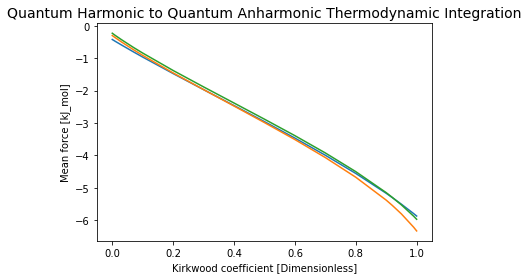

In [6]:
# Performs a TI from aharmonic reference to an anharmonic one.

CDIR = DROOT + "/QTI-HARM-TO-ANHARM/"
l_list = [l.decode('ascii') for l in np.loadtxt(CDIR + "LAMBDAS", dtype='S32')]

nfeq = 10
nfmax = 1000000
nblocks = 3
mf_blocks = np.zeros((len(l_list), nblocks))
e_blocks = np.zeros(nblocks)

for i,il in enumerate(l_list):
    U_harm = np.loadtxt(CDIR + str(il) + "/simulation.pots", usecols=(2))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ
    U_anharm = np.loadtxt(CDIR + str(il) + "/simulation.pots", usecols=(0))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ
    U_anharm += np.loadtxt(CDIR + str(il) + "/simulation.pots", usecols=(1))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ

    E = np.loadtxt(CDIR + str(il) + "/simulation.out", usecols=(4))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ
    E += np.loadtxt(CDIR + str(il) + "/simulation.out", usecols=(5))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ
    #np.random.shuffle(U_harm)
    #np.random.shuffle(U_anharm)
    
    mf_block_list = np.array_split((U_anharm - U_harm), nblocks)
    mf_blocks[i] = [np.mean(mf) for mf in mf_block_list]
    
    e_block_list = np.array_split((E), nblocks)
    e_blocks = [np.mean(e) for e in e_block_list]

dA_quantum_anharmonic_minus_harmonic_list = []
for j in range(nblocks):
    x = np.asarray([float(il) for il in l_list])
    y = mf_blocks.T[j]
    dA_quantum_anharmonic_minus_harmonic_list.append(np.trapz(x=x,y=y))
    plt.title("Quantum Harmonic to Quantum Anharmonic Thermodynamic Integration", fontsize=14)
    plt.xlabel('Kirkwood coefficient [Dimensionless]')
    plt.ylabel('Mean force [kJ_mol]')
    plt.plot(x, y)

dA_quantum_anharmonic_minus_harmonic = np.mean(dA_quantum_anharmonic_minus_harmonic_list)
dA_quantum_anharmonic_minus_harmonic_err =np.std(dA_quantum_anharmonic_minus_harmonic_list) / np.sqrt(nblocks)

A_anharm_quantum = A_harm_quantum + dA_quantum_anharmonic_minus_harmonic
A_anharm_quantum_err = dA_quantum_anharmonic_minus_harmonic_err

E_anharm_quantum = np.mean(e_blocks)
E_anharm_quantum_err = np.std(e_blocks) / np.sqrt(nblocks)

ST_anharm_quantum = E_anharm_quantum - A_anharm_quantum
ST_anharm_quantum_err = np.sqrt(A_anharm_quantum_err**2 + E_anharm_quantum_err**2)

print ("%-70s %-10s %-10.5f +/- %-10.5f" % ("Quantum anharmonic free energy", "[kJ_mol]", A_anharm_quantum, A_anharm_quantum_err))
print ("%-70s %-10s %-10.5f +/- %-10.5f" % ("Quantum anharmonic free energy - Quantum anharmonic free energy", "[kJ_mol]", A_anharm_quantum - A_harm_quantum, dA_quantum_anharmonic_minus_harmonic_err))

print ("")
print ("%-70s %-10s %-10.5f +/- %-10.5f" % ("Quantum anharmonic energy", "[kJ_mol]", E_anharm_quantum, E_anharm_quantum_err))

print ("")
print ("%-70s %-10s %-10.5f +/- %-10.5f" % ("Quantum anharmonic entropy", "[kJ_mol]", ST_anharm_quantum, ST_anharm_quantum_err))
print ("%-70s %-10s %-10.5f +/- %-10.5f" % ("d G / d T", "[kJ_mol / K]", -ST_anharm_quantum / T, -ST_anharm_quantum_err/ T))



In [7]:
if os.path.isdir(DROOT + "/PINPT/"):
    CDIR = DROOT + "/PINPT/"

    nfeq = 100
    nfmax = 1000000

    volume = np.loadtxt(CDIR + 'simulation.vir', usecols=(6,))[nfeq:nfeq + nfmax]
    v_blocks = [np.mean(v) for v in np.array_split(volume, nblocks)]
    
    dGdP = np.mean(v_blocks) / n_units * Bohr3tokJmolGPa
    dGdP_err = np.std(v_blocks) / np.sqrt(nblocks) / n_units * Bohr3tokJmolGPa

    CDIR = DROOT + "/HARM/"
    volume_nvt = np.loadtxt(CDIR + 'simulation.out', usecols=(2,))

    h_volume, e_volume = np.histogram(volume, 100, density=True)
    i_volume_nvt = np.argmin((e_volume-volume_nvt)**2)
    p_volume = np.log((h_volume[i_volume_nvt] + h_volume[i_volume_nvt + 1] + h_volume[i_volume_nvt -1]) / 3.0)

    p_ext = 0.1 * MPa2au

    dG_anharm_quantum = (p_ext * volume_nvt + kBT * p_volume * Hartree2Kcalmol / n_units * KcaltoKJ)
    G_anharm_quantum = A_anharm_quantum + dG_anharm_quantum

    print ("%-80s %-10s %-10.5f" % ("Quantum anharmonic Gibbs free energy", "[kJ_mol]", G_anharm_quantum))
    print ("%-80s %-10s %-10.5f" % ("Quantum anharmonic Gibbs free energy - Quantum anharmonic free energy", "[kJ_mol]", dG_anharm_quantum)) 
    print ("%-80s %-10s %-10.5f +/- %-10.5f" % ("d G / d P", "[kJ_mol / GPa]", dGdP, dGdP_err))

else:
    G_anharm_quantum = None 


Quantum anharmonic Gibbs free energy                                             [kJ_mol]   -98868.05428
Quantum anharmonic Gibbs free energy - Quantum anharmonic free energy            [kJ_mol]   -0.57475  
d G / d P                                                                        [kJ_mol / GPa] 67.60460   +/- 0.02152   


### CLASSICAL HARMONIC TO ANHARMONIC 

Classical anharmonic free energy                                       [kJ_mol]   -99059.67226
Classical anharmonic free energy - Classical anharmonic free energy    [kJ_mol]   -0.14533   +/- 0.00317   


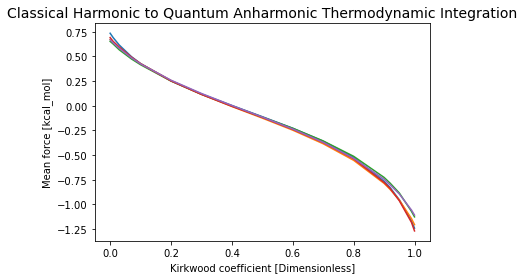

In [8]:
# Performs a TI from aharmonic reference to an anharmonic one.

CDIR = DROOT + "/CTI-HARM-TO-ANHARM/"
l_list = np.loadtxt(CDIR + "LAMBDAS", dtype='S32')
l_list = [l.decode('ascii') for l in np.loadtxt(CDIR + "LAMBDAS", dtype='S32')]


nfeq = 100
nfmax = 1000000
nblocks = 5
mf_blocks = np.zeros((len(l_list), nblocks))

for i,il in enumerate(l_list):
    U_harm = np.loadtxt(CDIR + str(il) + "/simulation.pots", usecols=(2))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ 
    U_anharm = np.loadtxt(CDIR + str(il) + "/simulation.pots", usecols=(0))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ 
    U_anharm += np.loadtxt(CDIR + str(il) + "/simulation.pots", usecols=(1))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ


    #np.random.shuffle(U_harm)
    #np.random.shuffle(U_anharm)
    
    mf_block_list = np.array_split(U_anharm - U_harm, nblocks)
    mf_blocks[i] = [np.mean(mf) for mf in mf_block_list]

dA_classical_anharmonic_minus_harmonic_list = []
for j in range(nblocks):
    x = np.asarray([float(il) for il in l_list])
    y = mf_blocks.T[j]
    dA_classical_anharmonic_minus_harmonic_list.append(np.trapz(x=x,y=y))
    plt.title("Classical Harmonic to Quantum Anharmonic Thermodynamic Integration", fontsize=14)
    plt.xlabel('Kirkwood coefficient [Dimensionless]')
    plt.ylabel('Mean force [kcal_mol]')
    plt.plot(x, y)

dA_classical_anharmonic_minus_harmonic = np.mean(dA_classical_anharmonic_minus_harmonic_list)
dA_classical_anharmonic_minus_harmonic_err =np.std(dA_classical_anharmonic_minus_harmonic_list) / np.sqrt(nblocks)

print ("%-70s %-10s %-10.5f" % ("Classical anharmonic free energy", "[kJ_mol]", A_harm_classical + dA_classical_anharmonic_minus_harmonic))
print ("%-70s %-10s %-10.5f +/- %-10.5f" % ("Classical anharmonic free energy - Classical anharmonic free energy", "[kJ_mol]", dA_classical_anharmonic_minus_harmonic, dA_classical_anharmonic_minus_harmonic_err))                         



In [9]:
if os.path.isdir(DROOT + "/PINPT/"):
    CDIR = DROOT + "/NPT/"

    nfeq = 100
    nfmax = 1000000

    volume = np.loadtxt(CDIR + 'simulation.vir', usecols=(6,))[nfeq:nfeq + nfmax]

    CDIR = DROOT + "/HARM/"
    volume_nvt = np.loadtxt(CDIR + 'simulation.out', usecols=(2,))

    h_volume, e_volume = np.histogram(volume, 100, density=True)
    i_volume_nvt = np.argmin((e_volume-volume_nvt)**2)
    p_volume = np.log((h_volume[i_volume_nvt] + h_volume[i_volume_nvt + 1] + h_volume[i_volume_nvt -1]) / 3.0)

    p_ext = 0.1 * MPa2au

    dG_anharm_classical = (p_ext * volume_nvt + kBT * p_volume * Hartree2Kcalmol / n_units * KcaltoKJ)
    G_anharm_classical = A_harm_classical + dA_classical_anharmonic_minus_harmonic + dG_anharm_classical

    print ("%-80s %-10s %-10.5f" % ("Classical anharmonic Gibbs free energy", "[kJ_mol]", G_anharm_classical))
    print ("%-80s %-10s %-10.5f" % ("Classical anharmonic Gibbs free energy - Quantum anharmonic free energy", "[kJ_mol]", dG_anharm_classical)) 
else:
    G_anharm_classical = None

Classical anharmonic Gibbs free energy                                           [kJ_mol]   -99060.32306
Classical anharmonic Gibbs free energy - Quantum anharmonic free energy          [kJ_mol]   -0.65080  


In [10]:
print ("Summary:")
print ("%-50s %-20s %-10.5f" % ("Minimum energy", "[kJ_mol]", Umin))
print ("%-50s %-20s %-10.5f" % ("Classical harmonic free energy", "[kJ_mol]", A_harm_classical))
print ("%-50s %-20s %-10.5f" % ("Classical anharmonic free energy", "[kJ_mol]", A_harm_classical + dA_classical_anharmonic_minus_harmonic))
print ("%-50s %-20s %-10.5f" % ("Quantum harmonic free energy", "[kJ_mol]", A_harm_quantum))
print ("%-50s %-20s %-10.5f" % ("Quantum anharmonic free energy", "[kJ_mol]", A_anharm_quantum))

if G_anharm_classical != None:
    print ("Gibbs free energy")
    print ("%-50s %-20s %-10.5f +/- %10.5f" % ("Classical anharmonic Gibbs free energy", "[kcal_mol]", G_anharm_classical,dA_classical_anharmonic_minus_harmonic_err))
if G_anharm_quantum != None:
    print ("%-50s %-20s %-10.5f +/- %10.5f" % ("Quantum anharmonic Gibbs free energy", "[kcal_mol]", G_anharm_quantum, A_anharm_quantum_err))


Summary:
Minimum energy                                     [kJ_mol]             -99133.26867
Classical harmonic free energy                     [kJ_mol]             -99059.52693
Classical anharmonic free energy                   [kJ_mol]             -99059.67226
Quantum harmonic free energy                       [kJ_mol]             -98864.46710
Quantum anharmonic free energy                     [kJ_mol]             -98867.47953
Gibbs free energy
Classical anharmonic Gibbs free energy             [kcal_mol]           -99060.32306 +/-    0.00317
Quantum anharmonic Gibbs free energy               [kcal_mol]           -98868.05428 +/-    0.03070


### CLASSICAL ANHARMONIC TO CLASSICAL ANHARMONIC

In [58]:
CDIR = DROOT + 'QTI-CL-TO-QN/'
l_list = np.loadtxt(CDIR + "G.DATA", dtype='S32')
l_list = np.insert(l_list, 0, '0.0')

nfeq = 100
nfmax = 1000000
nblocks = 5
mf_blocks = np.zeros((len(l_list), nblocks))

for i,il in enumerate(l_list):
    
    if i == 0:
        continue

    T_classical = 3.0 * float(N) * kBT / 2.0 * Hartree2Kcalmol / n_units * KcaltoKJ 
    T_quantum = np.loadtxt(CDIR + str(il) + '/simulation.out', usecols=(4,))[nfeq:nfeq + nfmax] * Hartree2Kcalmol / n_units * KcaltoKJ 
    
    np.random.shuffle(T_quantum)
    
    
    mf_block_list = np.array_split(2 * (T_quantum - T_classical) / float(il), nblocks)
    mf_blocks[i] = [np.mean(mf) for mf in mf_block_list]

dA_quantum_anharmonic_minus_classical_anharmonic_list = []
for j in range(nblocks):
    x = np.asarray([float(il) for il in l_list])
    y = mf_blocks.T[j]
    dA_quantum_anharmonic_minus_classical_anharmonic_list.append(np.trapz(x=x,y=y))
    plt.title("Classical Anharmonic to Quantum Anharmonic Thermodynamic Integration", fontsize=14)
    plt.xlabel('Alchemical factor [Dimensionless]')
    plt.ylabel('Mean force [kJ_mol]')
    plt.plot(x, y)

dA_quantum_anharmonic_minus_classical_anharmonic = np.mean(dA_quantum_anharmonic_minus_classical_anharmonic_list)
dA_quantum_anharmonic_minus_classical_anharmonic_err =np.std(dA_quantum_anharmonic_minus_classical_anharmonic_list) / np.sqrt(nblocks)

A_anharm_quantum = A_harm_classical + dA_classical_anharmonic_minus_harmonic + dA_quantum_anharmonic_minus_classical_anharmonic
A_anharm_quantum_err = (dA_classical_anharmonic_minus_harmonic_err**2 + dA_quantum_anharmonic_minus_classical_anharmonic**2)**0.50

print "%-70s %-10s %-10.5f" % ("Quantum anharmonic free energy", "[kcal_mol]", A_harm_classical + dA_classical_anharmonic_minus_harmonic + dA_quantum_anharmonic_minus_classical_anharmonic)
print "%-70s %-10s %-10.5f +/- %-10.5f" % ("Classical anharmonic free energy - Quantum anharmonic free energy", "[kcal_mol]", A_anharm_quantum - A_harm_quantum, dA_quantum_anharmonic_minus_classical_anharmonic_err)                         


SyntaxError: invalid syntax (<ipython-input-58-f198a6e1ddfd>, line 40)